In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from copy import deepcopy
from collections import Counter
from tqdm import tqdm
import timeit
import sys
import random
import warnings

pio.templates.default = "plotly_white"
np.random.seed(17)

## Introduction

In this series of notebooks, I have decided to explore concepts introduced in [Reinforcement learning: An introduction (2nd edition)](https://books.google.com/books/about/Reinforcement_Learning_second_edition.html?hl=fr&id=uWV0DwAAQBAJ) by Richard S. Sutton and Andrew G. Barto chapter by chapter. Each notebook contains code to reproduce the algorithms and visualizations of the book. We will dive deeper into the materials by exploring hands-on cases on public datasets to crystallize our understanding.

+ Multi-armed Bandits
+ Finite Markov Decision Processes
+ Dynamic Programming
+ Monte Carlo Methods
+ Temporal-Difference Learning
+ n-step Bootstrapping
+ Planing and Learning with Tabular Methods
+ On-policy Prediction with Approximation
+ On-policy Control with Approximation
+ Off-policy Methods with Approximation
+ Eligibility Traces
+ Policy Gradient Methods

## $k$-armed Bandit Problem

Consider the following learning problem. You are faced repeatedly with a choice among
$k$ different options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected.

This is the original form of the $k$-armed bandit problem, so named by analogy to a slot machine, or “one-armed bandit,” except that it has $k$ levers instead of one. Each action selection is like a play of one of the slot machine’s levers, and the rewards are the payoffs for hitting the jackpot.

__[Import Image of the k-bandit problem]__

Another analogy is that of a doctor choosing between experimental treatments for a series of seriously ill patients. Each action is the selection of a treatment, and each reward is the survival or well-being of the patient. As we will explore in the [case study](#case-study-post-hct-survival), the choice of the treatment could impact the survival of the patients recieving bone marrow transplantation.

In [29]:
class Bandit:
    def __init__(self, k: int, initial_value=0):
        self.k = k
        self.expected_values = np.random.normal(loc=0, scale=1, size=k)
        self.estimated_values = np.full(k, initial_value, dtype=float)
        self.action_counts = np.zeros(k)
        self.initial_value = initial_value

    def get_reward(self, action: int):
        return np.random.normal(loc=self.expected_values[action], scale=1)

    def update(self, action: int, reward: float, step_size=None):
        self.action_counts[action] += 1
        if not step_size:
            step_size = 1 / self.action_counts[action]
        self.estimated_values[action] += (reward - self.estimated_values[action]) * step_size

    def reset(self):
        self.expected_values = np.random.normal(loc=0, scale=1, size=self.k)
        self.estimated_values = np.full(self.k, self.initial_value, dtype=float)
        self.action_counts = np.zeros(self.k)

    def visualize(self):
        reward_distributions = []
        for action, expected_value in zip(list(range(1, self.k+1)), self.expected_values):
            rewards = np.random.normal(loc=expected_value, scale=1, size=500)
            reward_distributions.extend([(action, reward) for reward in rewards])
        
        warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na")
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        
        df = pd.DataFrame(reward_distributions, columns=["a", "r"])
        
        aspect = max(4, 1.5 * self.k)
        height = max(0.5, 10 / self.k)
        
        pal = sns.cubehelix_palette(self.k, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="a", hue="a", aspect=aspect, height=height, palette=pal)
        
        g.map(sns.kdeplot, "r",
              bw_adjust=5.0, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, "r", clip_on=False, color="w", lw=2, bw_adjust=5.0)
        
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
        
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)
        
        g.map(label, "r")
        
        def add_vline(*args, **kwargs):
            ax = plt.gca()
            ax.axvline(0, color='white', linestyle='--', linewidth=1.0)
        
        g.map(add_vline)
        
        g.figure.subplots_adjust(hspace=-.25)

        g.set_titles("")
        g.set_axis_labels("Reward distribution", "")
        g.set(xlim=(-10, 10), xticks=np.arange(-10, 11, 2))
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True);

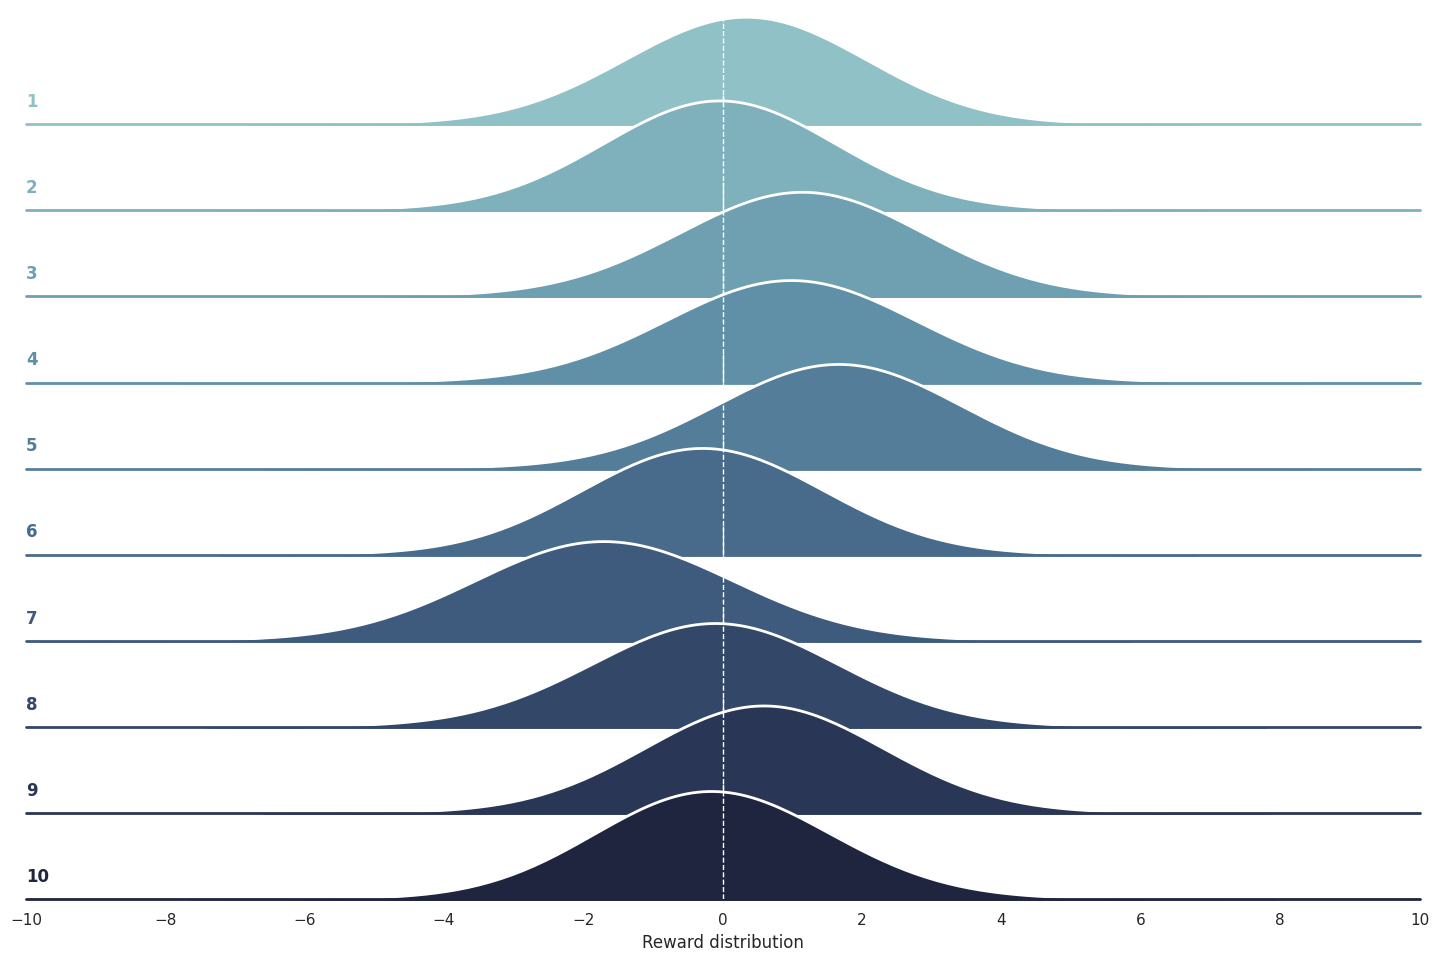

In [30]:
bandit = Bandit(k=10)
bandit.visualize()

In [37]:
bandit.expected_values

array([ 0.0394263 ,  1.12602722,  0.23382273, -0.02887222,  1.62078952,
       -1.07223944, -1.4003035 , -2.1469094 , -0.57867679,  0.09427081])

In [38]:
bandit.estimated_values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Exploration vs Exploitation

Exploration-Exploitation dillema is a fundamental concept of decision making that arises in many domains. Exploitation involves choosing the best option based on current knowledge of the system (which may be incomplete or misleading), while exploration involves trying out new options that may lead to better outcomes in the future at the expense of an exploitation opportunity.

__[Import Image of the apple analogy]__

![Exploration-vs-Exploitation Apple analogy](https://raw.githubusercontent.com/ammomahdavikia/RLBook/main/Ch02/Images/exploration-exploitation.png)

Exploitation is the right thing to do to maximize the expected reward on the one step, but exploration may produce the greater total reward in the long run. Reward is lower in the short
run, during exploration, but higher in the long run because after you have discovered the better actions, you can exploit them many times. Because it is not possible both to explore and to exploit with any single action selection, one often refers to the “conflict” between exploration and exploitation.

__[Import Exploration vs Exploitation comparision table]__

## Action-Value Methods

In our $k$-armed bandit problem, each of the $k$ actions has an __expected__ or __mean__ reward given that that action is selected; let us call this the _value_ of that action. We denote the action selected on time step $t$ as $A_t$, and the corresponding reward as $R_t$. The value then of an arbitrary action $a$, denoted $q_*(a)$, is the expected reward given that $a$ is selected:

$$q_*(a) \doteq \mathbb{E}[R_t | A_t=a]$$

But we don't know the acutal value of each action. Although we don't know the action values with certainty, we may have estimates. We denote the estimated value of action $a$ at time step $t$ as $Q_t(a)$. We would like $Q_t(a)$ to be close to $q*(a)$.

So we need methods for estimating the values of actions and for using the estimates to make action selection decisions, which we collectively call _action-value methods_. 

__[Import action-value two stage diagram]__

Recall that the true value of an action is the mean reward when that action is selected. One natural way to estimate this is by averaging the rewards actually received:

$$Q_t(a) \doteq \frac{sum\;of\;rewards\;when\;a\;taken\;prior\;to\;t}{number\;of\;times\;a\;taken\;prior\;to\;t} = \frac{\sum_{i=1}^{t-1}R_i.\mathbb{1}_{A_t=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_t=a}}$$

As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$. We call this the _sample-average method_ for estimating action values because each estimate is an average of the sample of relevant rewards. Of course this is just one way to estimate action values, and not necessarily the best one.

__[Import the GIF of the selection to convergence for 1 bandit]__

In [7]:
class Method:
    def select_action(self, bandit: Bandit) -> int:
        raise NotImplementedError("Implement in subclasses")

In [76]:
def select_color(methods):
    method_counts = Counter(method.__class__.__name__ for method in methods)
    palettes = {
        "EpsilonGreedyMethod": list(sns.cubehelix_palette(n_colors=method_counts.get("EpsilonGreedyMethod", 0), start=2, rot=-0.2)),
        "UCBMethod": list(sns.cubehelix_palette(n_colors=method_counts.get("UCBMethod", 0), rot=-.2)),
        "GradientMethod": list(sns.cubehelix_palette(n_colors=method_counts.get("GradientMethod", 0), rot=0.3))
    }
    colors = []
    for method in methods:
        if isinstance(method, EpsilonGreedyMethod):
            rgb = palettes["EpsilonGreedyMethod"][method_counts["EpsilonGreedyMethod"]-1]
            color = f'rgb({rgb[0]},{rgb[1]},{rgb[2]})'
            method_counts["EpsilonGreedyMethod"] -= 1
        elif isinstance(method, UCBMethod):
            rgb = palettes["UCBMethod"][method_counts["UCBMethod"]-1]
            color = f'rgb({rgb[0]},{rgb[1]},{rgb[2]})'
            method_counts["UCBMethod"] -= 1
        elif isinstance(method, GradientMethod):
            rgb = palettes["GradientMethod"][method_counts["GradientMethod"]-1]
            color = f'rgb({rgb[0]},{rgb[1]},{rgb[2]})'
            method_counts["GradientMethod"] -= 1
        else:
            rgb = np.array([128.,128.,128.])
            if method.step_size:
                rgb *= method.step_size
            color = f'rgb({rgb[0]},{rgb[1]},{rgb[2]})'
        colors.append(color)
    return colors

def select_legend(methods):
    legends = []
    for method in methods:
        if isinstance(method, EpsilonGreedyMethod):
            if method.step_size:
                legends.append(f"EpsilonGreedy (ε={method.epsilon}, α={method.step_size})")
            else:
                legends.append(f"EpsilonGreedy (ε={method.epsilon})")
        elif isinstance(method, UCBMethod):
            if method.step_size:
                legends.append(f"UCB (c={method.ucb_param}, α={method.step_size})")
            else:
                legends.append(f"UCB (c={method.ucb_param})")
        elif isinstance(method, GradientMethod):
            legends.append(f"Gradient (α={method.step_size})")
        elif isinstance(method, GreedyMethod):
            if method.step_size:
                legends.append(f"Greedy (α={method.step_size})")
            else:
                legends.append(f"Greedy")
        else:
            legends.append(f"{method.__class__.__name__}")
    return legends

def visualize_method(bandits, methods, num_steps, runs):
    colors = select_color(methods)
    legends = select_legend(methods)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Average Reward", "% Optimal Action-Selection"))

    for bandit_template in bandits:

        
        for idx, method_template in enumerate(methods):
            all_rewards = np.zeros(num_steps)
            all_optimals = np.zeros(num_steps)
            
            for _ in tqdm(range(runs), desc=f"{method_template.__class__.__name__}"):
                method = deepcopy(method_template) # Used deepcopy to ensure each run starts fresh.
                bandit = deepcopy(bandit_template)
                bandit.reset() # Reset random expected_values
                results = method.run(bandit, num_steps=num_steps)
                all_optimals += (results['action'] == bandit.expected_values.argmax()).astype('int')
                all_rewards += np.array(results['reward'])
    
            all_rewards /= runs
            all_optimals /= runs

            if bandit.initial_value != 0:
                dash='dash'
            else:
                dash='solid'
    
            # Average Reward
            fig.add_trace(go.Scatter(x=list(range(1, num_steps+1)), y=all_rewards,
                                     mode='lines', name=legends[idx],
                                     line=dict(color=colors[idx], dash=dash)),
                          row=1, col=1)
            
            # % Optimal Action-Selection
            fig.add_trace(go.Scatter(x=list(range(1, num_steps+1)), y=all_optimals * 100,
                                     mode='lines', name=legends[idx],
                                     line=dict(color=colors[idx], dash=dash), showlegend=False),
                          row=1, col=2)

    fig.update_layout(height=500, width=900,
                      title_text=f"{bandit.k}-armed Bandit",
                      showlegend=True)
    fig.update_yaxes(range=[0, 100], row=1, col=2)
    fig.show()

Now, that we learned how to estimate the value of action at each time step, we would explore the methods for making decision to select actions upon the estimated values.

The simplest action selection rule is to select one of the actions with the highest estimated value, it is called __greedy__ action selection method. Greedy action selection always exploits current knowledge to maximize immediate reward; it spends no time at all sampling apparently inferior actions to see if they might really be better. We write this greedy action selection method as:

$$A_t \doteq \underset{a}{\operatorname{argmax}}Q_t(a)$$

In [50]:
class GreedyMethod(Method):
    def __init__(self, step_size=None):
        self.step_size = step_size

    def select_action(self, bandit: Bandit) -> int:
        return np.argmax(bandit.estimated_values)

    def run(self, bandit: Bandit, num_steps):
        rewards = np.zeros(num_steps)
        actions = np.zeros(num_steps, dtype=int)
        for step in range(num_steps):
            action = self.select_action(bandit)
            reward = bandit.get_reward(action)
            bandit.update(action, reward, self.step_size)
            rewards[step] = reward
            actions[step] = action
        return {'reward': rewards, 'action': actions}

In [53]:
bandits = [Bandit(k=10)]
methods = [GreedyMethod()]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

GreedyMethod: 100%|██████████| 2000/2000 [00:11<00:00, 180.01it/s]


A simple alternative is to behave greedily most of the time, but every once in a while, say with small probability $\epsilon$, instead select randomly from among all the actions with equal probability, independently of the action-value estimates. We call methods using this near-greedy action selection rule __$\epsilon$-greedy methods__.

$$A_t \doteq
\begin{cases}
\underset{a}{\operatorname{argmax}}Q_t(a), & \text{with probability } 1 - \epsilon \\
\text{random action from } A, & \text{with probability } \epsilon
\end{cases}$$

__[Import the GIF of the comparison between greedy and non-greedy methods]__

In [54]:
class EpsilonGreedyMethod(Method):
    def __init__(self, epsilon: float, step_size=None):
        if 0 > epsilon or epsilon > 1:
            raise ValueError("epsilon must be between 0 and 1.")
        self.epsilon = epsilon
        self.step_size = step_size

    def select_action(self, bandit: Bandit) -> int:
        act_greedy = np.random.choice([0, 1], p=[self.epsilon, 1 - self.epsilon])
        if act_greedy:
            return np.argmax(bandit.estimated_values)
        return np.random.randint(bandit.k)

    def run(self, bandit: Bandit, num_steps):
        rewards = np.zeros(num_steps)
        actions = np.zeros(num_steps, dtype=int)
        for step in range(num_steps):
            action = self.select_action(bandit)
            reward = bandit.get_reward(action)
            bandit.update(action, reward, self.step_size)
            rewards[step] = reward
            actions[step] = action
        return {'reward': rewards, 'action': actions}

In [55]:
bandits = [Bandit(k=10)]
methods = [
    EpsilonGreedyMethod(epsilon=0.2),
    EpsilonGreedyMethod(epsilon=0.1),
    EpsilonGreedyMethod(epsilon=0.01),
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

EpsilonGreedyMethod: 100%|██████████| 2000/2000 [00:56<00:00, 35.33it/s]


In [56]:
bandits = [Bandit(k=10)]
methods = [
    GreedyMethod(),
    EpsilonGreedyMethod(epsilon=0.1),
    EpsilonGreedyMethod(epsilon=0.01),
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

EpsilonGreedyMethod: 100%|██████████| 2000/2000 [00:58<00:00, 34.08it/s]


## Incremental Implementation

The obvious implementation would be to maintain a record of all the rewards and then perform sample-average computation whenever the estimated value was needed. However, if this is done, then the memory and computational requirements would grow over time as more rewards are seen. Each additional reward would require additional memory to store it
and additional computation to compute the sum in the numerator.

If we rewrite the value estimation seperately for each action as follow:



Then,

$$Q_{n+1} = \frac{1}{n} \sum_{i=1}^{n} R_i$$

$$= \frac{1}{n} \left( R_n + \sum_{i=1}^{n-1} R_i \right)$$

$$= \frac{1}{n} \left( R_n + (n - 1) \cdot \frac{1}{n - 1} \sum_{i=1}^{n-1} R_i \right) $$

$$= \frac{1}{n} \left( R_n + (n - 1) Q_n \right)$$

$$= \frac{1}{n} \left( R_n + n Q_n - Q_n \right)$$

$$= Q_n + \frac{1}{n} \left[ R_n - Q_n \right]$$

This implementation requires memory only for $Q_n$ and $n$, and only the small computation for each new reward.

$$NewEstimate\leftarrow OldEstimate + StepSize\;[Target-OldEstimate]$$

The expression $[Target-OldEstimate]$ is an __error__ in the estimate. It is reduced by taking a step toward the “Target.” The target is presumed to indicate a desirable direction in which to move, though it may be noisy. 

In [64]:
k = 10
estimated_values = [0] * k
action_counts = [0] * k

In [65]:
def incremental_update(steps=10000):
    for _ in range(steps):
        action = random.randint(0, k-1)
        reward = random.gauss(0, 1)
        action_counts[action] += 1
        estimated_values[action] += (reward - estimated_values[action]) / action_counts[action]

In [ ]:
inc_time = timeit.timeit(lambda: incremental_update(10000), number=1)
inc_memory = sys.getsizeof(estimated_values) + sys.getsizeof(action_counts)

print(f"Incremental - Time: {inc_time:.4f}s, Memory: {inc_memory} bytes")

In [ ]:
rewards = {i: [] for i in range(k)}

def non_incremental_update(steps=10000):
    for _ in range(steps):
        action = random.randint(0, k-1)
        reward = random.gauss(0, 1)
        rewards[action].append(reward)
    
    estimated_values = [sum(rewards[i]) / len(rewards[i]) if rewards[i] else 0 for i in range(k)]

In [ ]:
non_inc_time = timeit.timeit(lambda: non_incremental_update(10000), number=1)
non_inc_memory = sys.getsizeof(rewards) + sum(sys.getsizeof(v) for v in rewards.values())

print(f"Non-Incremental - Time: {non_inc_time:.4f}s, Memory: {non_inc_memory} bytes")

In [ ]:
# time difference between incremental and base approaches

## Tracking a Nonstationary Problem

The averaging methods discussed so far are appropriate for stationary bandit problems, that is, for bandit problems in which the reward probabilities do not change over time.

We often encounter reinforcement learning problems that are effectively nonstationary. In such cases it makes sense to give more weight to recent rewards than to long-past rewards. One of the most popular ways of doing this is to use a constant step-size parameter.

$$Q_{n+1} \doteq Q_n + \alpha \left[ R_n - Q_n \right]$$

where the step-size parameter $\alpha \in (0, 1]$ is constant. Incrementally speaking:

$$Q_{n+1} = (1 - \alpha)^n Q_1 + \sum_{i=1}^{n} \alpha (1 - \alpha)^{n - i} R_i$$

We call this a weighted average because the sum of the weights is $(1 - \alpha)^n + \sum_{i=1}^{n} \alpha (1 - \alpha)^{n - i} =1$, as you can check for yourself. Accordingly, this is sometimes called an _exponential recency-weighted average_.

__[Question: Step-size paramter condition]__

In [78]:
bandits = [Bandit(k=10)]
methods = [
    GreedyMethod(),
    GreedyMethod(step_size=0.1),
    EpsilonGreedyMethod(epsilon=0.1),
    EpsilonGreedyMethod(epsilon=0.1, step_size=0.1)
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

EpsilonGreedyMethod: 100%|██████████| 2000/2000 [00:58<00:00, 33.99it/s]


## Optimistic Initial Values

All the methods we have discussed so far are dependent to some extent on the initial action-value estimates, $Q_1(a)$. In the language of statistics, these methods are biased by their initial estimates. The downside is that the initial estimates become, in effect, a set of parameters that must be picked by the user, if only to set them all to zero. The upside is that they provide an easy way to supply some prior knowledge about what level of rewards can be expected.

Suppose that instead of setting the initial action values to zero, we set them all to +5. This optimism encourages action-value methods to explore. Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to other actions, being “disappointed” with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

__[GIF for optimistic initial value]__

In [79]:
bandits = [Bandit(k=10),
           Bandit(k=10, initial_value=5)]
methods = [
    GreedyMethod(),
    EpsilonGreedyMethod(epsilon=0.1),
    EpsilonGreedyMethod(epsilon=0.01),
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

EpsilonGreedyMethod: 100%|██████████| 2000/2000 [00:56<00:00, 35.67it/s]


## Upper-Confidence-Bound Action Selection

Exploration is needed because there is always uncertainty about the accuracy of the action-value estimates. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. One effective way of doing this is to select actions according to:

$$A_t \doteq \underset{a}{\operatorname{argmax}} \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$$

where $\ln t$ denotes the natural logarithm of $t$ (the number that $e = 2.71828$ would have to be raised to in order to equal $t$), $N_t(a)$ denotes the number of times that action $a$ has been selected prior to time $t$, and the number $c > 0$ controls
the degree of exploration.

__[GIF for UCB]__

In [60]:
class UCBMethod(Method):
    def __init__(self, ucb_param: float):
        if ucb_param <= 0:
            raise ValueError("ucb_param must be more than zero.")
        self.ucb_param = ucb_param

    def select_action(self, bandit: Bandit, step) -> int:
        exploration_bonus = np.zeros(bandit.k)
        for i in range(bandit.k):
            if bandit.action_counts[i] == 0:
                # Large finite value for unexplored actions
                exploration_bonus[i] = 1e6  
            else:
                exploration_bonus[i] = self.ucb_param * np.sqrt(
                    np.log(step + 1) / bandit.action_counts[i]
                )
        return np.argmax(bandit.estimated_values + exploration_bonus)

    def run(self, bandit: Bandit, num_steps, step_size=None):
        rewards = np.zeros(num_steps)
        actions = np.zeros(num_steps, dtype=int)
        for step in range(num_steps):
            action = self.select_action(bandit, step)
            reward = bandit.get_reward(action)
            bandit.update(action, reward, step_size)
            rewards[step] = reward
            actions[step] = action
        return {'reward': rewards, 'action': actions}

In [61]:
bandits = [Bandit(k=10)]
methods = [
    UCBMethod(ucb_param=.1),
    UCBMethod(ucb_param=1.),
    UCBMethod(ucb_param=2.),
    UCBMethod(ucb_param=10.),
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

UCBMethod: 100%|██████████| 2000/2000 [01:30<00:00, 22.13it/s]


## Gradient Bandit algorithm

In this section we consider learning a numerical preference for each action $a$, which we denote $H_t(a) \in \mathbb{R}$. The larger the preference, the more often that action is
taken, but the preference has no interpretation in terms of reward. Only the relative
preference of one action over another is important.

Action probabilities, are determined according to a soft-max distribution (i.e., Gibbs or Boltzmann distribution) as follows:

$$Pr\{A_t = a\} \doteq \frac{e^{H_t(a)}}{\sum^k_{b=1}e^{H_t(b)}} \doteq \pi_t(a)$$

where here we have also introduced a useful new notation, $\pi_t(a)$, for the probability of taking action $a$ at time $t$. Keep $\pi_t(a)$ in mind as we will elaborate more in the upcoming notebooks.

In [80]:
class GradientMethod(Method):
    def __init__(self, step_size: float):
        if step_size <= 0:
            raise ValueError("step_size must be more than zero.")
        self.step_size = step_size
        self.preferences = None

    def select_action(self, bandit: Bandit) -> int:
        if self.preferences is None:
            self.preferences = np.zeros(bandit.k)
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))
        action_probabilities = exp_preferences / np.sum(exp_preferences)
        return np.random.choice(bandit.k, p=action_probabilities)

    def run(self, bandit: Bandit, num_steps, step_size=None):
        rewards = np.zeros(num_steps)
        actions = np.zeros(num_steps, dtype=int)
        avg_reward = 0
        
        for step in range(num_steps):
            action = self.select_action(bandit)
            reward = bandit.get_reward(action)
            
            avg_reward += (reward - avg_reward) / (step + 1)
            
            exp_preferences = np.exp(self.preferences - np.max(self.preferences))
            action_probabilities = exp_preferences / np.sum(exp_preferences)
            
            for a in range(bandit.k):
                if a == action:
                    self.preferences[a] += self.step_size * (reward - avg_reward) * (1 - action_probabilities[a])
                else:
                    self.preferences[a] -= self.step_size * (reward - avg_reward) * action_probabilities[a]
            
            rewards[step] = reward
            actions[step] = action
            
        return {'reward': rewards, 'action': actions}

In [82]:
bandits = [Bandit(k=10)]
methods = [
    GradientMethod(step_size=0.01),
    GradientMethod(step_size=0.1),
    GradientMethod(step_size=0.3),
    GradientMethod(step_size=1.)
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

GradientMethod: 100%|██████████| 2000/2000 [02:19<00:00, 14.33it/s]


In [83]:
bandits = [Bandit(k=10)]
methods = [
    GreedyMethod(step_size=0.1),
    EpsilonGreedyMethod(epsilon=0.1),
    UCBMethod(ucb_param=3.),
    GradientMethod(step_size=0.1),
]

visualize_method(bandits, methods, num_steps=1000, runs=2000)

AttributeError: 'UCBMethod' object has no attribute 'step_size'

## Associative search

So far in this chapter we have considered only nonassociative tasks, that is, tasks in which there is no need to associate different actions with different situations. In these tasks the learner either tries to find a single best action when the task is stationary, or tries to track the best action as it changes over time when the task is nonstationary. 

However, in a general reinforcement learning task there is more than one situation, and the goal is to learn a policy: a mapping from situations to the actions that are best in those situations.

__[Example design]__

This is an example of an associative search task, so called because it involves both trial-and-error learning to search for the best actions, and association of these actions with the situations in which they are best. Associative search tasks are often now called contextual bandits in the literature. Associative search tasks are intermediate between the $k$-armed bandit problem and the full reinforcement learning problem.

## Case Study (Post-HCT Survival)

## Summary

### Keywords

+ Associative
+ Nonassociative
+ Stationary
+ Nonstationary
+ Exploration
+ Exploitation
+ Average sampling
+ Posterior sampling or Thompson sampling
+ Action-value methods
+ Greedy method
+ $\epsilon$-Greedy method
+ Upper Confidence Bound (UCB) method
+ Gradient bandit algorithm
+ Preference
+ Soft-max distribution (i.e., Gibbs or Boltzmann distribution)
+ Optimistic initial value

### Resources

### Citation